# Covid restrictions.

**Setting up the environment**
Initialization of the Ontology editor in Jupyter Notebook

In [1]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np
import pandas as pd
import pickle
import datetime

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    


Lets setup the fist ontology editor for the general knowledge. The editor allows you to enter the knowledge in text format, and support you with the prdictive editor.

In [2]:
parts_editors={}
parts_editors['01']=CnlEditBox('countries.encnl')
parts_editors['02']=CnlEditBox('border_cross_quarantine.encnl')
parts_editors['03']=CnlEditBox('face_cover.encnl')
parts_editors['04']=CnlEditBox('lockdown.encnl')
parts_editors['05']=CnlEditBox('mass_coronavirus_testing.encnl')

<IPython.core.display.Javascript object>

In [3]:
parts_editors['01']

In [4]:
parts_editors['02']

In [5]:
parts_editors['03']

In [6]:
parts_editors['04']

In [7]:
parts_editors['05']

Lets define the function that will build the ontology based on the dict of ontology editors and the optional additional editor for testing purposes. All it is doing it is concatenaiting the values of all the editors and puts them into the newly created ontology object.

In [8]:
def buildOntology(parts_editors,test_editor=None):
    return Ontology("cnl/string",
                    "\n\n".join(k.getvalue() for k in parts_editors.values())+('' if test_editor is None else test_editor.getvalue()), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

onto=buildOntology(parts_editors)

Lets draw our ontology.

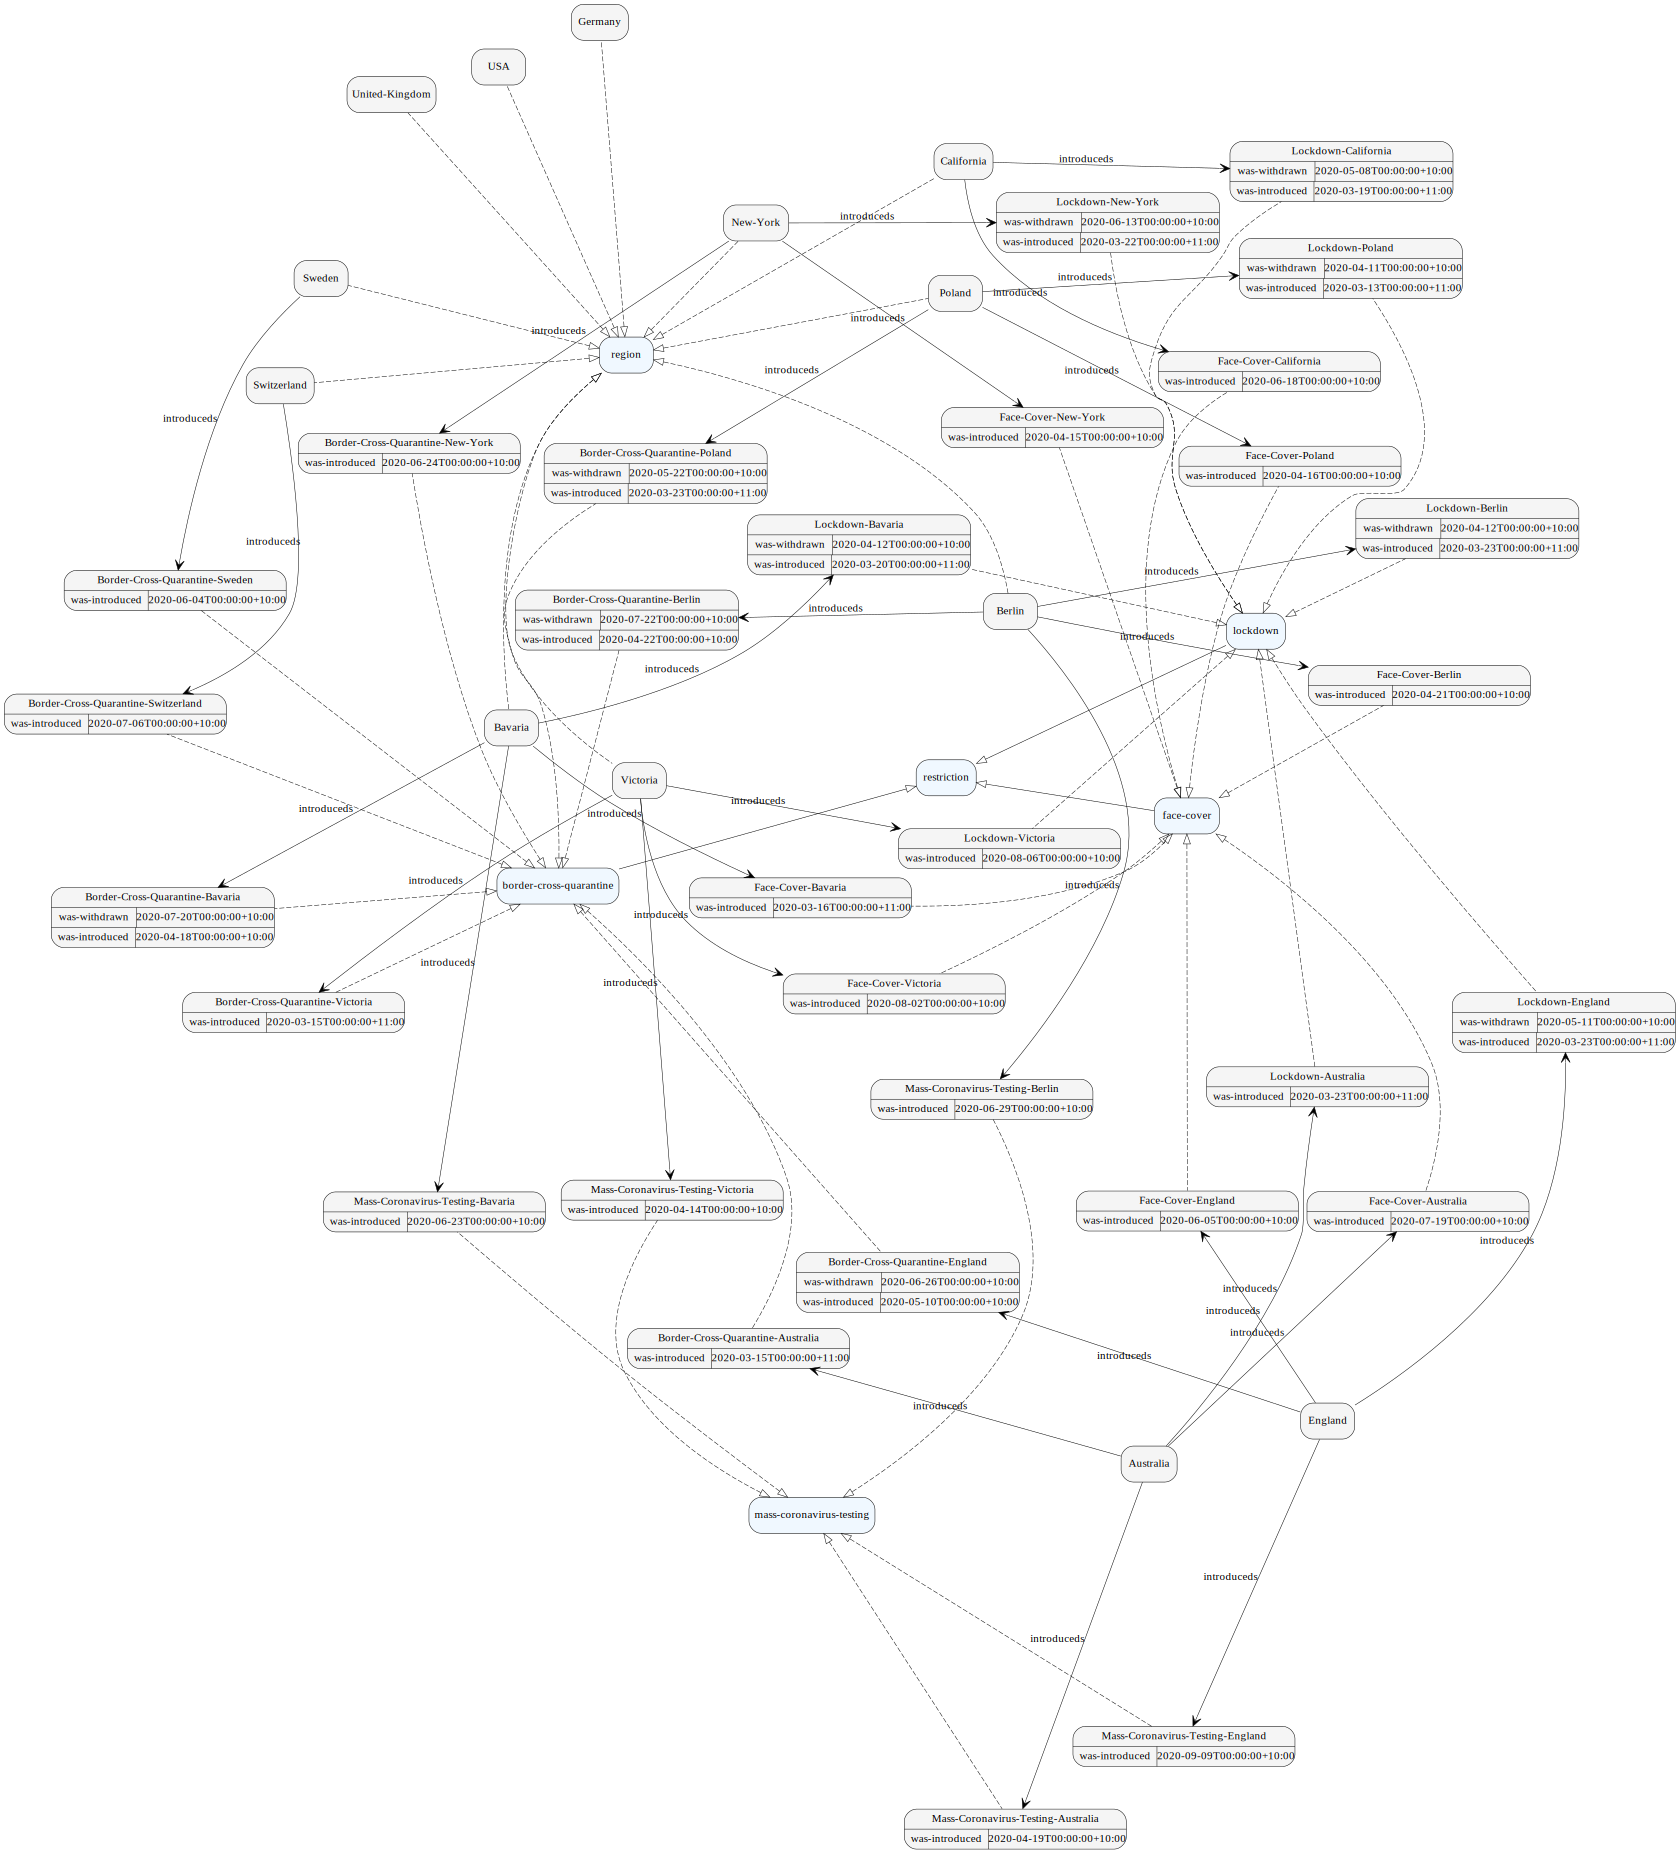

In [9]:
onto.draw_graph(layout='force directed')

You can select and print out all instaces of given concept's name.

In [10]:
onto.select_instances_of("region")

,Instance,introduceds
0,Victoria,"[Mass-Coronavirus-Testing-Victoria, Lockdown-V..."
1,Berlin,"[Mass-Coronavirus-Testing-Berlin, Lockdown-Ber..."
2,United-Kingdom,None
3,Bavaria,"[Mass-Coronavirus-Testing-Bavaria, Lockdown-Ba..."
4,New-York,"[Lockdown-New-York, Face-Cover-New-York, Borde..."
5,California,"[Lockdown-California, Face-Cover-California]"
6,Sweden,Border-Cross-Quarantine-Sweden
7,Poland,"[Lockdown-Poland, Face-Cover-Poland, Border-Cr..."
8,Germany,None
9,USA,None


Cognipy allows you to do queries on ontology using sparql language. In example we query for every region which has indtroduced some restriction and then we save it to pandas dataframe. 

In [11]:
df=onto.sparql_query(CQL("""select ?region ?restriction ?date{
                            ?region rdf:type <region>. 
                            ?restriction rdf:type <restriction>. 
                            ?region <introduceds> ?restriction. 
                            ?restriction <was-introduced> ?date.
                        }"""))

In [12]:
df['date'] = pd.to_datetime(pd.to_datetime(df['date']).apply(lambda x: x.strftime('%d/%m/%Y')))
df.set_index('date',inplace=True)

Lets import covid cases data.

In [13]:
covid_data = pd.read_csv('data.csv', index_col=0)
covid_data.index = covid_data.index.str.replace(' ', '-')
covid_data = covid_data.T

In [14]:
covid_data.index = pd.to_datetime(covid_data.index)

In [15]:
covid_data

,New-South-Wales,Victoria,Finland,Germany,New-Zealand,Norway,Poland,Sweden,Switzerland,US,United-Kingdom
2020-01-22,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,1,0
2020-01-24,0,0,0,0,0,0,0,0,0,2,0
2020-01-25,0,0,0,0,0,0,0,0,0,2,0
2020-01-26,3,1,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,4273,20269,11580,320495,1870,15388,116338,98451,60368,7663293,575679
2020-10-10,4278,20281,11849,323463,1871,15466,121638,98451,60368,7717932,590844
2020-10-11,4284,20295,11998,326309,1871,15524,125816,98451,60368,7762546,603716
2020-10-12,4295,20307,12212,332850,1872,15639,130210,98451,64436,7804199,617688


In [16]:
new_cases = covid_data.diff(periods=7).dropna()

In [17]:
new_cases

,New-South-Wales,Victoria,Finland,Germany,New-Zealand,Norway,Poland,Sweden,Switzerland,US,United-Kingdom
2020-01-29,4.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
2020-01-30,4.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2020-01-31,4.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0
2020-02-01,4.0,4.0,1.0,8.0,0.0,0.0,0.0,1.0,0.0,6.0,2.0
2020-02-02,1.0,3.0,1.0,10.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,41.0,72.0,1336.0,22121.0,21.0,1104.0,20565.0,4168.0,5984.0,330996.0,108533.0
2020-10-10,44.0,72.0,1458.0,23436.0,17.0,1104.0,23498.0,4168.0,5984.0,335591.0,110827.0
2020-10-11,49.0,75.0,1460.0,24736.0,16.0,1067.0,25742.0,4168.0,5984.0,344701.0,100738.0
2020-10-12,49.0,74.0,1510.0,28177.0,14.0,1034.0,28130.0,4168.0,8504.0,346797.0,102117.0


In [18]:
from matplotlib import pyplot as plt
%matplotlib inline 

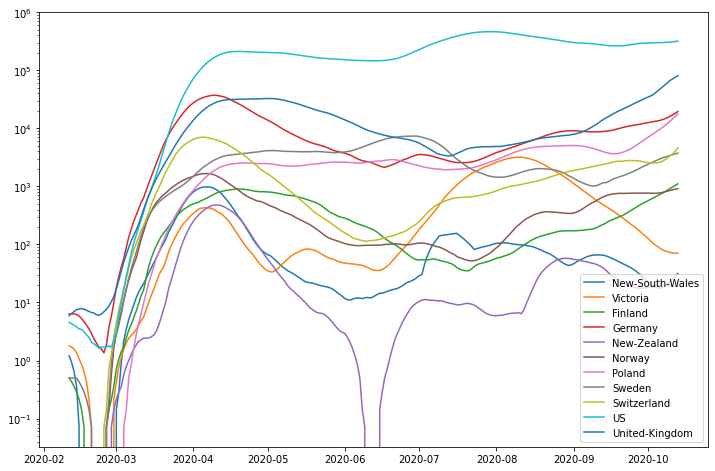

In [19]:
plt.figure(figsize=(12,8))

rolling14 = new_cases.rolling(window=14).mean()
for column in rolling14.columns:
    plt.plot(rolling14.index, rolling14[column], label=column)

plt.legend(loc=4)
plt.yscale("log")

plt.show()

Figure shows covid new cases in time on logarythmic scale.

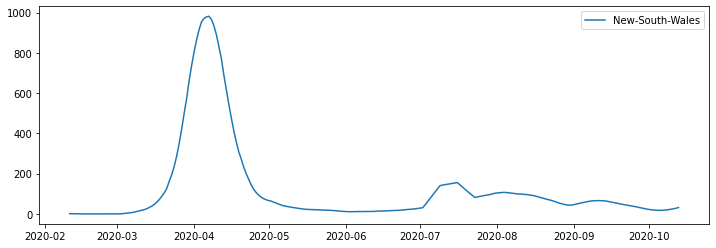

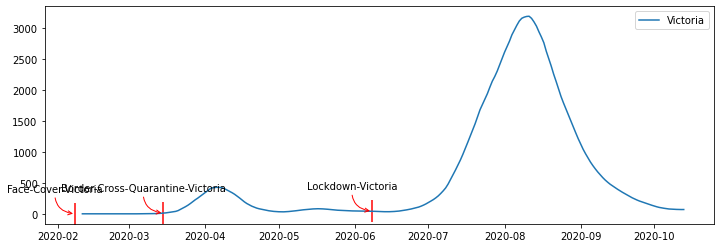

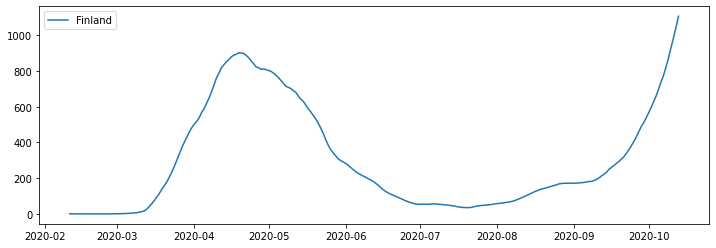

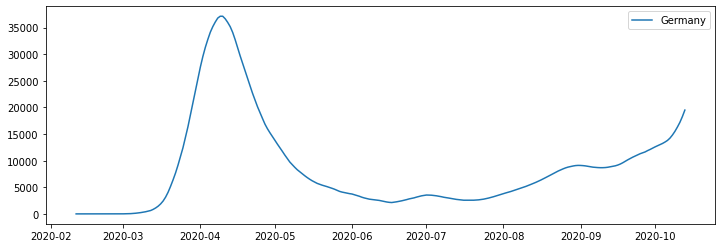

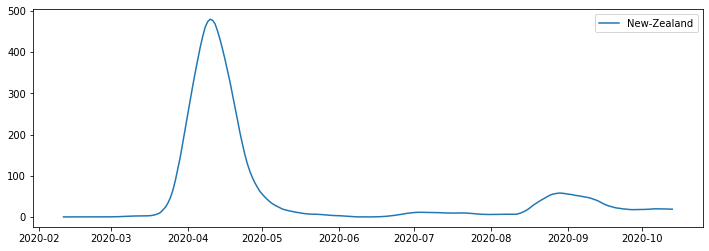

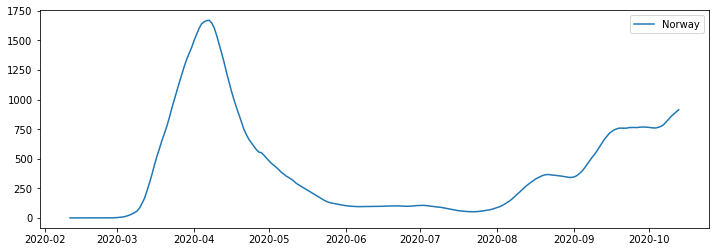

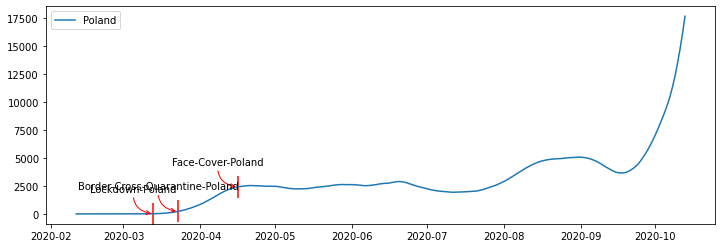

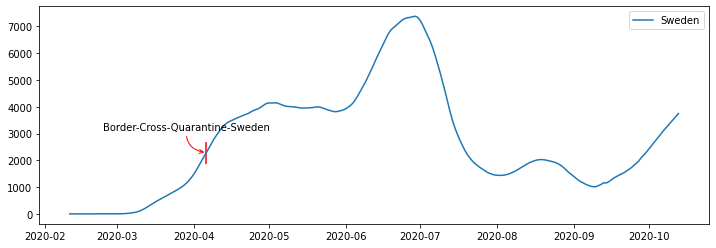

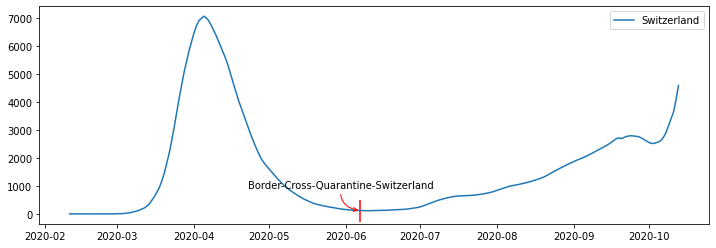

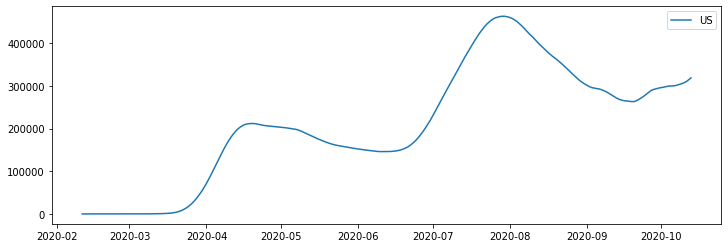

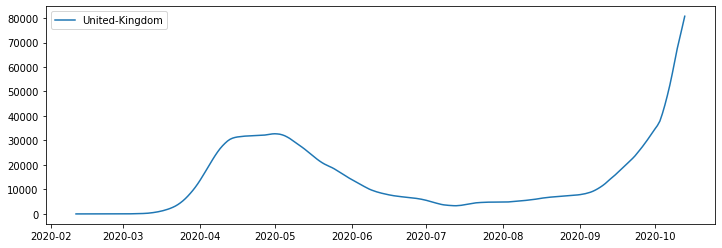

In [36]:
for i, column in enumerate(rolling14.columns):
    plt.figure(figsize=(12,4))
    plt.plot(rolling14.index, rolling14[column], label=column)
    plt.legend()
    for datex,row in df[df["region"]==column].iterrows():
        val =rolling14[column].loc[datex]
        val = 0.0 if val!=val else val
        plt.scatter(datex, val , marker="|", s=500, c="red")
        plt.annotate(row.restriction, (datex, val), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->',
            connectionstyle='arc3,rad=0.5', color='red'))
    plt.show()

Plots contains marks on them which show when given restrcion was introduced.